# Watch a temperature : scan temperature *v* time

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Wed-00:31:18 - ############################################################ startup
I Wed-00:31:18 - logging started
I Wed-00:31:18 - logging level = 10
I Wed-00:31:18 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/collection.py
I Wed-00:31:18 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/mpl/notebook.py
I Wed-00:31:18 - #### Bluesky Framework ####
I Wed-00:31:18 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check_python.py
I Wed-00:31:18 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Wed-00:31:18 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/initialize.py
I Wed-00:31:19 - using databroker catalog 'class_2021_03'
I Wed-00:31:19 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/metadata.py
I Wed-00:31:19 - #### Devices ####
I Wed-00:31:19 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/area_detector.py
I Wed-00:31:19 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/calculation_records.py
I Wed-00:31:21 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/ioc_stats.py
I Wed-00:31:21 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/motors.py
I Wed-00:31:21 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/devices/noisy_det

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-03-17 00:31:23.069706
temperature_readback          25.0                                2021-03-17 00:31:23.070703
temperature_done              True                                2021-03-17 00:31:23.075505
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-03-17 00:31:23.071409
temperature_description       temperature                         2021-03-17 00:31:23.067918
temperature_max_change        2.0                                 2021-03-17 00:31:23.071165
temperature_noise             1.0                                 2021-03-17 00:31:23.070703
temperature_previous_value_pv gp:userCalc8.VAL                    2021

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to count the temperature.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 29     Time: 2021-03-17 00:31:23
Persistent Unique Scan ID: '8e2b3b52-f481-43a0-9060-e941d6f2d11c'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 00:31:23.3 |             25.25967 |
+-----------+------------+----------------------+
generator count ['8e2b3b52'] (scan num: 29)


('8e2b3b52-f481-43a0-9060-e941d6f2d11c',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 30     Time: 2021-03-17 00:31:23
Persistent Unique Scan ID: 'aab735d5-738c-4428-912f-0c7e74f04b30'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 00:31:23.8 |             25.25967 |
|         2 | 00:31:23.8 |             25.25967 |
|         3 | 00:31:23.8 |             25.25967 |
|         4 | 00:31:23.9 |             25.25967 |
|         5 | 00:31:23.9 |             25.25967 |
|         6 | 00:31:23.9 |             25.25967 |
|         7 | 00:31:23.9 |             25.25967 |
|         8 | 00:31:23.9 |             25.25967 |
|         9 | 00:31:24.0 |             25.25967 |
|        10 | 00:31:24.0 |             25.25967 |
+-----------+------------+----------------------+
generator count ['aab735d5'] (scan num: 30)


('aab735d5-738c-4428-912f-0c7e74f04b30',)

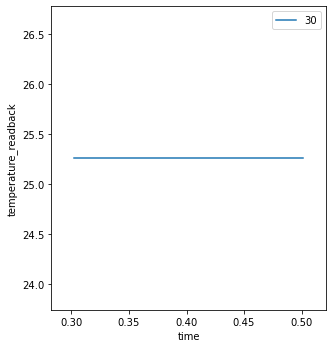

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  (If there are two different values, we caught the moment when EPICS updated the calculation.)  The table above showed `temperature_scanning_rate 5` which means EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 31     Time: 2021-03-17 00:31:24
Persistent Unique Scan ID: '0ac9f009-e731-42f2-abf3-c2e36cb70d0e'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 00:31:24.5 |             25.25967 |
|         2 | 00:31:26.5 |             25.17826 |
|         3 | 00:31:28.5 |             25.13952 |
|         4 | 00:31:30.5 |             24.88978 |
|         5 | 00:31:32.5 |             24.94393 |
|         6 | 00:31:34.5 |             24.55808 |
|         7 | 00:31:36.5 |             25.37408 |
|         8 | 00:31:38.5 |             24.79841 |
|         9 | 00:31:40.5 |             24.92800 |
|        10 | 00:31:42.5 |             24.58536 |
+-----------+------------+----------------------+
generator count ['0ac9f009'] (scan num: 31)


('0ac9f009-e731-42f2-abf3-c2e36cb70d0e',)

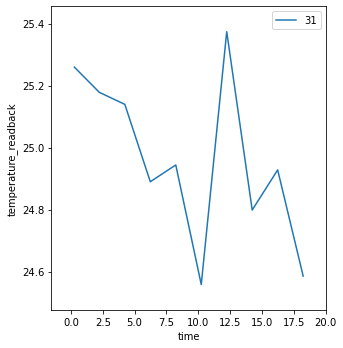

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the shortest interval EPICS provides, so our measurements do not take so long.

In [7]:
# print the list of possible values
print(temperature.scanning_rate.enum_strs)

# set the shortest interval, by name
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

('Passive', 'Event', 'I/O Intr', '10 second', '5 second', '2 second', '1 second', '.5 second', '.2 second', '.1 second')


'2 second'

## Collect our measurements
Repeat the measurement, this time with more observations.

Also, we'll add a metadata key:value pair so that later we can find this data more easily in the database.  Most plans take a `md={}` kwarg where the value is a Python dictionary with the key:value pair(s) to add to the run's metadata.



Transient Scan ID: 32     Time: 2021-03-17 00:31:44
Persistent Unique Scan ID: 'be32b29f-0b3d-44f7-93d8-b20bb535f767'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 00:31:45.1 |             24.80861 |
|         2 | 00:31:45.1 |             25.27551 |
|         3 | 00:31:45.2 |             24.52997 |
|         4 | 00:31:45.3 |             25.26422 |
|         5 | 00:31:45.4 |             25.22010 |
|         6 | 00:31:45.5 |             24.59462 |
|         7 | 00:31:45.6 |             24.74448 |
|         8 | 00:31:45.7 |             25.47461 |
|         9 | 00:31:45.8 |             24.74518 |
|        10 | 00:31:45.9 |             24.55061 |
|        11 | 00:31:46.0 |             25.28276 |
|        12 | 00:31:46.1 |             24.64104 |
|        13 | 00:31:46.3 |             24.90211 |
|        14 | 00:31:46.4 |         

('be32b29f-0b3d-44f7-93d8-b20bb535f767',)

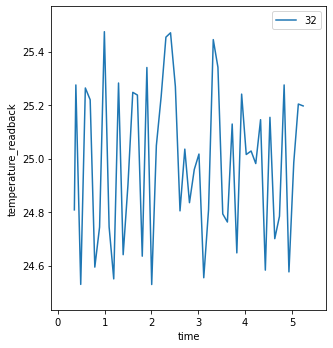

In [8]:
RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ==================
measure value             
======= ==================
max     25.474608987563897
mean    24.99029221026932 
dev     0.2877445557256184
min     24.529587243457694
#       50                
======= ==================



Let's replot that data for comparison.

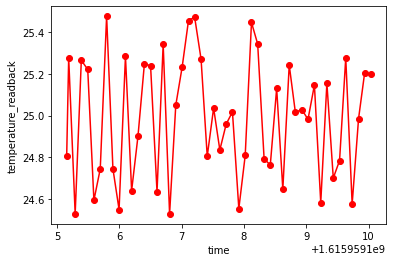

In [12]:
dataset["temperature_readback"].plot(marker="o", color="red")